In [ ]:
import pandas as pd

In [ ]:
url = "https://raw.githubusercontent.com/dustywhite7/Econ8310/master/AssignmentData/cookie_cats.csv"
df = pd.read_csv(url)

In [ ]:
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


,0
userid,0
version,0
sum_gamerounds,0
retention_1,0
retention_7,0


In [ ]:
df['retention_1'] = df['retention_1'].astype(int)
df['retention_7'] = df['retention_7'].astype(int)

In [ ]:
grouped = df.groupby('version')[['retention_1', 'retention_7']].agg(['sum', 'count'])
print(grouped)

        retention_1        retention_7       
                sum  count         sum  count
version                                      
gate_30       20034  44700        8502  44700
gate_40       20119  45489        8279  45489


Output()

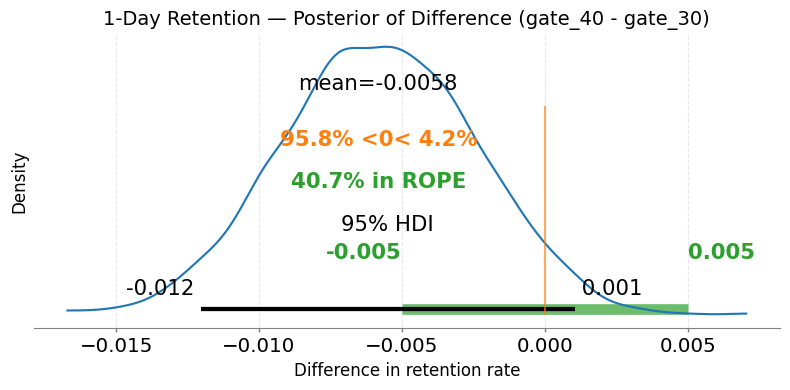

→ Probability that gate_40 > gate_30: 0.042


Output()

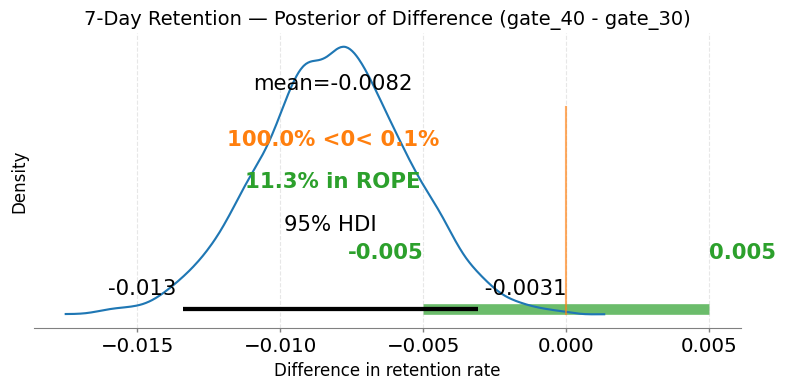

→ Probability that gate_40 > gate_30: 0.001


In [1]:
# Install required packages
!pip install pymc arviz --quiet

# Import libraries
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Known summary stats from dataset
ret1_30, n1_30 = 20034, 44700
ret1_40, n1_40 = 20119, 45489

ret7_30, n7_30 = 8502, 44700
ret7_40, n7_40 = 8279, 45489

# Define reusable Bayesian A/B test function
def bayesian_ab_test(success_a, total_a, success_b, total_b, title="Retention"):
    with pm.Model() as model:
        # Priors
        p_a = pm.Beta("p_a", alpha=1, beta=1)
        p_b = pm.Beta("p_b", alpha=1, beta=1)

        # Likelihoods
        pm.Binomial("obs_a", n=total_a, p=p_a, observed=success_a)
        pm.Binomial("obs_b", n=total_b, p=p_b, observed=success_b)

        # Posterior difference
        delta = pm.Deterministic("delta", p_b - p_a)

        # Sampling
        trace = pm.sample(2000, tune=1000, return_inferencedata=True, progressbar=True)

    # Plot posterior of delta
    az.plot_posterior(
        trace,
        var_names=["delta"],
        hdi_prob=0.95,
        point_estimate="mean",
        ref_val=0,
        rope=[-0.005, 0.005],
        figsize=(8, 4)
    )
    plt.title(f"{title} — Posterior of Difference (gate_40 - gate_30)", fontsize=14)
    plt.xlabel("Difference in retention rate", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print probability
    prob = (trace.posterior["delta"] > 0).mean().item()
    print(f"→ Probability that gate_40 > gate_30: {prob:.3f}")

# Run analysis
bayesian_ab_test(ret1_30, n1_30, ret1_40, n1_40, title="1-Day Retention")
bayesian_ab_test(ret7_30, n7_30, ret7_40, n7_40, title="7-Day Retention")
